<a href="https://colab.research.google.com/github/JudahGazit/reinforcement-learning-project/blob/main/Reinforcement_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install box2d gym[box2d]
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U pyglet

     |████████████████████████████████| 1.3 MB 8.3 MB/s 
     |████████████████████████████████| 448 kB 67.6 MB/s 
     |████████████████████████████████| 1.1 MB 7.5 MB/s 
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.5.22 which is incompatible.


In [ ]:
import random
import sys
import itertools
import json
import logging
import warnings

import gym
import imageio
from keras import Input
from keras.layers import Dense
import keras.models
import keras.optimizer_v2
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
%matplotlib inline

warnings.filterwarnings("ignore")
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
logging.basicConfig(format='[%(asctime)s] [%(levelname)s] %(message)s', stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('Agent')

Instructions for updating:
non-resource variables are not supported in the long term


# Display in Colab

In [ ]:
from pyvirtualdisplay import Display
import os

display = Display(visible=False, size=(1400, 900))
display.start()

In [ ]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def display_video(frames, temp_video_name='video.mp4'):
    imageio.mimsave(temp_video_name, frames, fps=30)
    mp4 = open(temp_video_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html = HTML(f"""<video width=400 controls><source src="{data_url}" type="video/mp4"></video>""")
    return html

# Clipped D3QN

In [ ]:
class ReplayMemory:
    def __init__(self, max_size, num_actions):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0
        self.mean = 0
        self.std = 1
        self.std_reward = 1
        self.epsilon = 1e-12
        self.action_count = [0] * num_actions

    def append(self, obj):
        if self.index < self.size:
            self.action_count[self.buffer[self.index][1]] -= 1
        self.action_count[obj[1]] += 1
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        return random.sample(self.buffer[:self.size], batch_size)

    def update_mead_std(self):
        states = np.array(self.buffer[:self.size])[:, 0]
        rewards = np.array(self.buffer[:self.size])[:, 2]
        self.mean = np.mean(states, 0)
        self.std = np.std(states, 0)
        self.std_reward = np.std(rewards)

    def normalize_state(self, states):
        normed = (states - self.mean) / (self.std + self.epsilon)
        return normed

    def normalize_reward(self, reward):
        return reward / (self.std_reward + self.epsilon)

    def __len__(self):
        return self.size

In [ ]:
class DDDQN:
    def __init__(self, num_features, num_actions, batch_frames, learning_rate, action_step_size, gamma=0.99):
        self.gamma = gamma
        self.num_features = num_features
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.batch_frames = batch_frames
        self.action_step_size = action_step_size
        self.q1 = self.create_model()
        self.q1_target = self.create_model()
        self.q2 = self.create_model()
        self.q2_target = self.create_model()
        self.copy_to_target()

    def create_model(self):
        number_of_features = self.num_features * self.batch_frames
        X_input = Input(number_of_features)
        X = X_input
        X = Dense(512, activation='relu')(X)
        X = Dense(512, activation='relu')(X)
        X = Dense(256, activation='relu')(X)
        advantage = Dense(self.num_actions)(X)
        value = Dense(1)(X)
        X = value + (advantage - tf.math.reduce_mean(advantage, axis=1, keepdims=True))
        model = keras.Model(inputs=X_input, outputs=X)
        model.compile(loss="mse",
                      optimizer=keras.optimizer_v2.rmsprop.RMSprop(learning_rate=self.learning_rate, clipvalue=1))
        return model

    def copy_to_target(self):
        self.q1_target.set_weights(self.q1.get_weights())
        self.q2_target.set_weights(self.q2.get_weights())

    def _create_targets(self, state, action, reward, next_state, done):
        targets_1 = self.q1.predict(state, batch_size=len(state))
        targets_2 = self.q2.predict(state, batch_size=len(state))
        next_action = self.q1.predict(next_state, batch_size=len(state)).argmax(1)
        Q_future_1 = self.q1_target.predict(next_state, batch_size=len(state))[np.arange(len(targets_1)), next_action]
        Q_future_2 = self.q2_target.predict(next_state, batch_size=len(state))[np.arange(len(targets_2)), next_action]
        discounted_rewards = reward + (1 - done) * np.minimum(Q_future_1, Q_future_2) * self.gamma
        td_error = np.abs(targets_1[np.arange(len(targets_1)), action] - discounted_rewards)
        targets_1[np.arange(len(targets_1)), action] = discounted_rewards
        targets_2[np.arange(len(targets_2)), action] = discounted_rewards
        return targets_1, targets_2, td_error.mean()

    def predict(self, states):
        return self.q1.predict(states, batch_size=len(states))

    def fit(self, state, action, reward, next_state, is_done):
        targets_1, targets_2, td_error = self._create_targets(state, action, reward, next_state, is_done)
        self.q1.fit(state, targets_1, epochs=1, verbose=False, batch_size=len(state), shuffle=False)
        self.q2.fit(state, targets_2, epochs=1, verbose=False, batch_size=len(state), shuffle=False)
        return td_error

    def save(self, name):
        self.q1.save(f'{name}.h5')

    def load(self, name):
        self.q1 = keras.models.load_model(f'{name}.h5')
        self.q2 = keras.models.load_model(f'{name}.h5')

In [ ]:
class WalkerAgent:
    """
    Walker agent to resolve the `BipedalWalker` environment.
    Uses Clipped D3QN (Clipped Double Dueling Deep Q Network) with replay buffer and discrete action space.

    :param env: gym environemnt name
    :param batch_frames: number of frames to stack together
    :param action_step_size: number of steps to use in each axis. Since BipedalWalker has 4 axes, the total number of actions is 3^4 - 1
    :param copy_to_target_at: copy weights to target network every `copy_to_target_at` episodes
    :param learning_rate: learning rate to be used
    :param learn_every: only sample and train every `learn_every` steps
    :param initial_steps: number of random steps before actual training begins
    :param batch_size: batch size to sample from buffer
    :param initial_epsilon: initial epsilon used in e-greedy policy
    :param final_epsilon: final epsilon used in e-greedy policy
    :param epsilon_decay: epsilon used in e-greedy policy. Decays every episode until reaching `final_epsilon`
    :param replay_memory_size: size of replay memory to be used
    """
    def __init__(self, env, batch_frames, action_step_size=3, copy_to_target_at=5, learning_rate=0.00005478,
                 learn_every=2, initial_steps=5000, batch_size=128, initial_epsilon=1, final_epsilon=0.01,
                 epsilon_decay=0.99, replay_memory_size=1_000_000):
        super().__init__()
        self.env_name = env
        self.env = gym.make(self.env_name).env

        self.batch_frames = batch_frames
        self.copy_to_target_at = copy_to_target_at
        self.learn_every = learn_every
        self.minimum_states = initial_steps
        self.batch_size = batch_size
        self.epsilon = initial_epsilon
        self.epsilon_min = final_epsilon
        self.epsilon_decay = epsilon_decay
        self.replay_memory_size = replay_memory_size
        self.action_step_size = action_step_size
        self.learning_rate = learning_rate

        for k, v in self.__dict__.items():
            if k != 'env':
                logger.info(f'Setting param: {k} = {v}')

        self.action_space = self._make_action_space(action_step_size)
        self.replay_memory = ReplayMemory(self.replay_memory_size, len(self.action_space))
        self.model = DDDQN(self.env.observation_space.shape[0], len(self.action_space), self.batch_frames,
                           self.learning_rate, self.action_step_size)

    def _make_action_space(self, action_step_size):
        number_of_axes = self.env.action_space.shape[0]
        actions = itertools.product(*[np.linspace(-1, 1, action_step_size) for _ in range(number_of_axes)])
        actions = np.array(list(actions))
        actions = actions[(np.sum(actions != 0, 1) <= 4) & (np.sum(actions != 0, 1) > 0)]
        return actions

    def _sample_from_replay(self, stored):
        """
        Biased sampling from the replay buffer. If `stored` is not None, samples (batch_size - 1) samples from the buffer
        and appends to `stored`.
        """
        if stored is not None:
            return np.concatenate([self.replay_memory.sample(self.batch_size - 1), [stored]])
        return np.array(self.replay_memory.sample(self.batch_size))

    def _train_episode(self, episode_number, episode_length):
        state = self.reset()
        total_reward = 0
        losses_of_trial = []
        for step in range(episode_length):
            state, reward, is_done, loss = self._step(state, step)
            total_reward += reward
            losses_of_trial.append(loss)
            if is_done.any():
                break
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        loss_of_trial = np.mean(losses_of_trial)
        if episode_number % self.copy_to_target_at == 0:
            self.model.copy_to_target()
        self._log_episode(episode_number, loss_of_trial, total_reward)
        return total_reward, loss_of_trial

    def _step(self, state, step_number, train=True):
        action = self.act(state, stochastic=train)
        next_state = np.array([self.env.step(self.action_space[action]) for _ in range(self.batch_frames)])
        next_state, reward, is_done, info = [np.hstack(next_state[:, i]) for i in range(next_state.shape[1])]
        reward_clipped = np.clip(reward.sum(), -10, 1)
        if train:
            is_terminal = is_done.any() and reward_clipped < -5
            stored = self.remember(state, action, reward_clipped, next_state, is_terminal)
            loss = 0
            if step_number > 0 and step_number % self.learn_every == 0:
                loss = self.learn_over_replay(stored)
            return next_state, np.max([reward.sum(), -100]), is_done.any(), loss
        else:
            return next_state, np.max([reward.sum(), -100]), is_done.any()

    def _log_episode(self, episode_number, loss_of_trial, total_reward):
        logger.info(
            '\t|\t'.join([f'Episode {str.zfill(str(episode_number), 4)}',
                          f'Reward {total_reward:.4f}',
                          f'Queue {len(self.replay_memory)}',
                          f'Epsilon {self.epsilon:.4f}',
                          f'Loss {loss_of_trial:.4f}'])
        )

    def _evaluate_episode(self, trial, episode_length, current_max, save_directory,
                          evaluate_freq=10, evaluate_threshold=300, evaluate_count=20):
        mean_rewards = None
        if trial % evaluate_freq == 0:
            mean_rewards = np.mean([np.sum(self.play(episode_length, False)) for i in range(evaluate_count)])
            to_stop = mean_rewards > evaluate_threshold
            logger.info(f'Avg in step {trial} = {mean_rewards}')
            if save_directory and (current_max is None or mean_rewards > current_max):
                self.save(f'{save_directory}/step_{trial}_score_{mean_rewards}')
                current_max = mean_rewards
        else:
            to_stop = False
        return to_stop, current_max, mean_rewards

    def learn_over_replay(self, stored=None):
        if len(self.replay_memory) >= self.minimum_states:
            samples = self._sample_from_replay(stored)
            state, action, rewards, next_state, is_done = [samples[:, i] for i in range(samples.shape[1])]
            state = self.replay_memory.normalize_state(np.vstack(state))
            next_state = self.replay_memory.normalize_state(np.vstack(next_state))
            rewards = self.replay_memory.normalize_reward(rewards).astype(np.float32)
            loss = self.model.fit(state, action.astype(int), rewards, next_state, is_done)
            return loss
        else:
            self.replay_memory.update_mead_std()
            self.epsilon = 1
        return 0

    def remember(self, state, action, reward, new_state, done):
        payload = [state, action, reward, new_state, done]
        self.replay_memory.append(payload)
        return payload

    def act(self, state, stochastic=True):
        """
        e-greedy policy, biased toward unpopular actions.
        The replay buffer keeps the amount of time each action was taken. Sampling an action according to action popularity.

        Let p_i be the frequency of action i in the replay buffer. The probability of picking action i in the e-greedy policy
        is proportionate to (1 - p_i).

        :param state: current state
        :param stochastic: if false, only picks deterministic actions. Otherwise - e-greedy policy
        :return: single action index
        """
        action = np.argmax(self.model.predict(self.replay_memory.normalize_state(state.reshape(1, -1))), 1)[0]
        if (np.random.random() < self.epsilon) and stochastic:
            if self.replay_memory.size:
                weights = np.array([1 - a / self.replay_memory.size for a in self.replay_memory.action_count])
                action = np.random.choice(len(self.action_space), p=weights / np.sum(weights))
            else:
                action = random.choices(range(len(self.action_space)))[0]
        return action

    def train(self, episodes=3000, episode_length=2000, save_directory=None, return_info=False):
        losses = []
        total_rewards = []
        scores = []
        current_max = None
        to_stop = False
        for trial in range(episodes):
            if not to_stop:
                total_reward, loss = self._train_episode(trial, episode_length)
                total_rewards.append(total_reward)
                losses.append(loss)
                to_stop, current_max, score = self._evaluate_episode(trial, episode_length, current_max, save_directory)
                if score is not None:
                    scores.append(score)
        return (total_rewards, losses, scores) if return_info else self

    def play(self, length=2000, render=True):
        state = self.reset()
        states = [state]
        frames = []
        rewards = []
        for i in range(length):
            state, reward, is_done = self._step(state, i, train=False)
            states.append(state)
            rewards.append(reward)
            if render:
                frames.append(self.env.render(mode='rgb_array'))
            if is_done:
                break
        return (rewards, frames) if render else rewards

    def reset(self):
        state = self.env.reset()
        state = np.hstack([state for _ in range(self.batch_frames)])
        return state

    def save(self, name):
        self.model.save(name)
        json.dump({str(k): str(v) for (k, v) in self.replay_memory.__dict__.items()
                   if k not in ('buffer',) and not k.startswith('__')},
                  open(f'{name}.json', 'w'))

    def load(self, name):
        self.model.load(name)
        j = json.load(open(f'{name}.json'))
        for k, v in j.items():
            if '[' in v:
                v = np.fromstring(v[1:-1].replace(',', ''), sep=' ')
            elif float(v).is_integer():
                v = int(v)
            else:
                v = float(v)
            setattr(self.replay_memory, k, v)
        return self


# BipedalWalker

In [ ]:
env_name = "BipedalWalker-v3"
batch_frames = 2
walker_agent = WalkerAgent(env_name, batch_frames)
rewards, losses, scores = walker_agent.train(3000, 1000, return_info=True)

[2022-03-11 15:27:27,336] [INFO] Setting param: env_name = BipedalWalker-v3
[2022-03-11 15:27:27,342] [INFO] Setting param: batch_frames = 2
[2022-03-11 15:27:27,344] [INFO] Setting param: copy_to_target_at = 5
[2022-03-11 15:27:27,349] [INFO] Setting param: learn_every = 2
[2022-03-11 15:27:27,356] [INFO] Setting param: minimum_states = 5000
[2022-03-11 15:27:27,366] [INFO] Setting param: batch_size = 128
[2022-03-11 15:27:27,373] [INFO] Setting param: epsilon = 1
[2022-03-11 15:27:27,382] [INFO] Setting param: epsilon_min = 0.01
[2022-03-11 15:27:27,391] [INFO] Setting param: epsilon_decay = 0.99
[2022-03-11 15:27:27,399] [INFO] Setting param: replay_memory_size = 1000000
[2022-03-11 15:27:27,406] [INFO] Setting param: action_step_size = 3
[2022-03-11 15:27:27,407] [INFO] Setting param: learning_rate = 5.478e-05
[2022-03-11 15:27:30,238] [INFO] Episode 0000	|	Reward -119.7151	|	Queue 28	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-11 15:28:31,461] [INFO] Avg in step 0 = -61.02020354262264

In [ ]:
walker_agent.save('bipedal_walker_model')

## Game Plots

Evaluate Model
Mean Reward at 100 trials 303.7251594890578


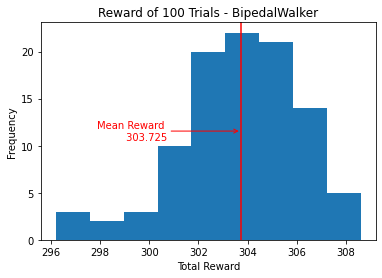

In [ ]:
print('Evaluate Model')

eval_scores = []
for _ in tqdm(range(100)):
    eval_scores.append(np.sum(walker_agent.play(1000, False)))

print('Mean Reward at 100 trials', np.mean(eval_scores))
plt.hist(eval_scores, 'auto')
plt.title('Reward of 100 Trials - BipedalWalker')
line_height = plt.gca().get_ylim()[1]
plt.vlines(np.mean(eval_scores), 0, line_height, 'r')
plt.annotate(f'Mean Reward \n {np.mean(eval_scores):.3f}', 
             (np.mean(eval_scores), line_height / 2), 
             xytext=(np.mean(eval_scores) - 3, line_height / 2), 
             ha='right', va='center', 
             arrowprops=dict(color='red', arrowstyle='->'), 
             color='red')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.ylim(0, line_height)
plt.show()

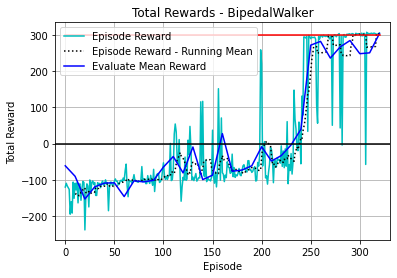

In [ ]:
rewards = np.array(rewards)
scores = np.array(scores)
running_mean = np.array([rewards[i-10:i].mean() for i in range(10, len(rewards))])

plt.plot(np.arange(len(rewards)), rewards, '-c',
         np.arange(len(rewards))[-len(running_mean):], running_mean, ':k',
         np.arange(len(scores)) * 10, scores, '-b',
         [0, len(rewards)], [300, 300], '-r',
         [-10, len(rewards) + 10], [0, 0], '-k',
         )
plt.legend(['Episode Reward', 'Episode Reward - Running Mean', 'Evaluate Mean Reward'])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards - BipedalWalker')
plt.xlim(-10, len(rewards) + 10)
plt.grid()

In [ ]:
play_rewards, frames = walker_agent.play(1000, True)
print('Total Reward=', np.sum(play_rewards))
display_video(frames)

Total Reward= 305.6108001427457
[2022-03-11 16:48:13,901] [WARNING] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 600) to (400, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to None (risking incompatibility). You may also see a FFMPEG warning concerning speedloss due to data not being aligned.


# BipedalWalker-Hardcore

In [ ]:
env_name = "BipedalWalkerHardcore-v3"
batch_frames = 2
hardcore_walker_agent = WalkerAgent(env_name, batch_frames)
hardcore_rewards, hardcore_losses, hardcore_scores = hardcore_walker_agent.train(3000, 1000, return_info=True)

[2022-03-10 22:56:08,684] [INFO] Episode 0000	|	Reward -107.3678	|	Queue 24	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:08,782] [INFO] Episode 0001	|	Reward -102.2774	|	Queue 63	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:09,257] [INFO] Episode 0002	|	Reward -108.0055	|	Queue 237	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:09,376] [INFO] Episode 0003	|	Reward -117.1236	|	Queue 277	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:09,820] [INFO] Episode 0004	|	Reward -136.2822	|	Queue 417	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:09,950] [INFO] Episode 0005	|	Reward -101.0569	|	Queue 451	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:10,105] [INFO] Episode 0006	|	Reward -115.0363	|	Queue 492	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:10,205] [INFO] Episode 0007	|	Reward -103.9578	|	Queue 518	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:10,299] [INFO] Episode 0008	|	Reward -112.5537	|	Queue 543	|	Epsilon 1.0000	|	Loss 0.0000
[2022-03-10 22:56:10,392] [INF

In [ ]:
hardcore_walker_agent.save('bipedal_walker_hardcore_model')

## Game Plots

Evaluate Model
Mean Reward at 100 trials 293.47634325019993


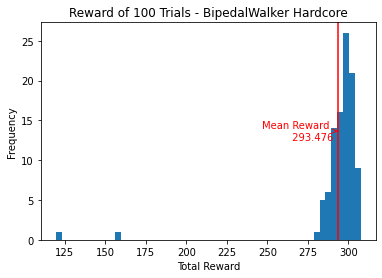

In [ ]:
print('Evaluate Model')

hardcore_eval_scores = []
for _ in tqdm(range(20)):
    hardcore_eval_scores.append(np.sum(hardcore_walker_agent.play(1000, False)))

print('Mean Reward at 100 trials', np.mean(hardcore_eval_scores))
plt.hist(hardcore_eval_scores, 'auto')
plt.title('Reward of 100 Trials - BipedalWalker Hardcore')
line_height = plt.gca().get_ylim()[1]
plt.vlines(np.mean(hardcore_eval_scores), 0, line_height, 'r')
plt.annotate(f'Mean Reward \n {np.mean(hardcore_eval_scores):.3f}', 
             (np.mean(hardcore_eval_scores), line_height / 2), 
             xytext=(np.mean(hardcore_eval_scores) - 3, line_height / 2), 
             ha='right', va='center', 
             arrowprops=dict(color='red', arrowstyle='->'), 
             color='red')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.ylim(0, line_height)
plt.show()

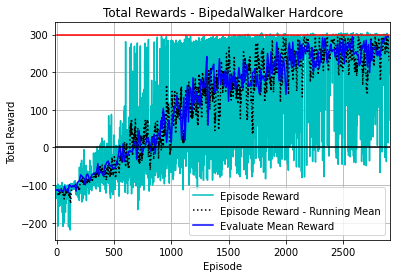

In [ ]:
hardcore_rewards = np.array(hardcore_rewards)
hardcore_scores = np.array(hardcore_scores)
running_mean = np.array([hardcore_rewards[i-10:i].mean() for i in range(10, len(hardcore_rewards))])

plt.plot(np.arange(len(hardcore_rewards)), hardcore_rewards, '-c',
         np.arange(len(hardcore_rewards))[-len(running_mean):], running_mean, ':k',
         np.arange(len(hardcore_scores)) * 10, hardcore_scores, '-b',
         [0, len(hardcore_rewards)], [300, 300], '-r',
         [-10, len(hardcore_rewards) + 10], [0, 0], '-k',
         )
plt.legend(['Episode Reward', 'Episode Reward - Running Mean', 'Evaluate Mean Reward'])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards - BipedalWalker Hardcore')
plt.xlim(-10, len(hardcore_rewards) + 10)
plt.grid()

In [ ]:
play_rewards, frames = hardcore_walker_agent.play(1000, True)
print('Total Reward=', np.sum(play_rewards))
display_video(frames)

Total Reward= 302.3381099066312
[2022-03-12 17:42:43,198] [WARNING] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 600) to (400, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to None (risking incompatibility). You may also see a FFMPEG warning concerning speedloss due to data not being aligned.
